# General Changepoint Detection Examples

This notebook demonstrates changepoint detection beyond neuroscience applications.
Examples include classic datasets from various domains to show the general applicability of changepoint modeling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..', '..'))

from pytau.changepoint_model import (
    SingleTastePoisson,
    GaussianChangepointMean2D,
    advi_fit
)
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Example 1: Coal Mining Disasters (1851-1962)

Classic changepoint example from the literature. The data represents the number of coal mining disasters per year in the UK.
We expect a changepoint around 1890 when safety regulations improved.

Reference: https://lindeloev.github.io/mcp/articles/poisson.html

In [2]:
# Coal mining disaster data (1851-1962)
coal_years = np.array([1851, 1852, 1853, 1854, 1856, 1857, 1858, 1859, 1860, 1861,
                       1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
                       1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881,
                       1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,
                       1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901,
                       1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
                       1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
                       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
                       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
                       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
                       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962])

coal_disasters = np.array([1, 7, 5, 1, 1, 5, 3, 5, 2, 5,
                          6, 3, 4, 5, 3, 5, 3, 5, 2, 5,
                          6, 6, 3, 4, 2, 6, 3, 3, 5, 2,
                          2, 1, 4, 2, 1, 3, 2, 2, 1, 1,
                          1, 1, 1, 3, 0, 0, 1, 0, 1, 1,
                          0, 0, 3, 1, 0, 3, 2, 2, 0, 1,
                          1, 1, 0, 1, 0, 1, 0, 0, 0, 2,
                          1, 0, 0, 0, 1, 1, 0, 2, 3, 3,
                          1, 1, 2, 1, 1, 1, 1, 2, 3, 3,
                          0, 0, 0, 1, 4, 0, 0, 0, 1, 0,
                          0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0])

print(f"Data spans {coal_years[0]} to {coal_years[-1]}")
print(f"Total disasters: {coal_disasters.sum()}")
print(f"Mean disasters per year: {coal_disasters.mean():.2f}")

Data spans 1851 to 1962
Total disasters: 198
Mean disasters per year: 1.78


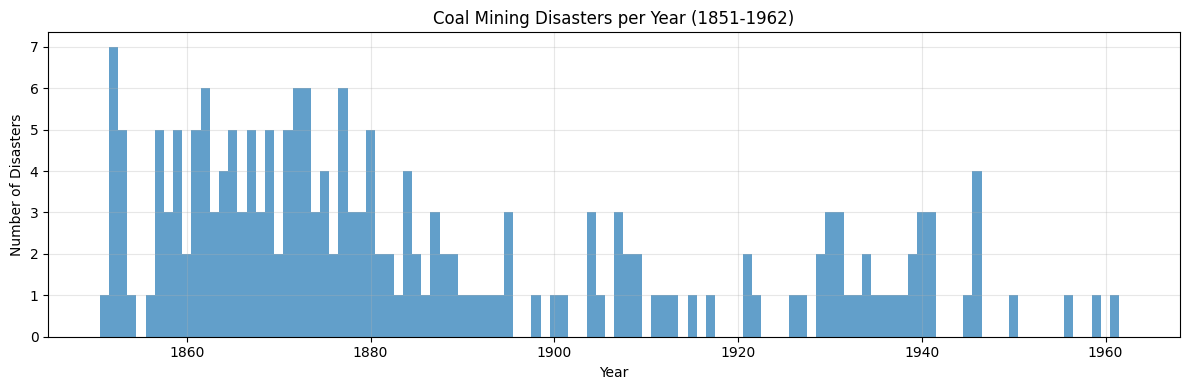

In [3]:
# Visualize the data
plt.figure(figsize=(12, 4))
plt.bar(coal_years, coal_disasters, width=1.0, alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Number of Disasters')
plt.title('Coal Mining Disasters per Year (1851-1962)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Prepare data for PyTau (3D format: trials x neurons x time)
coal_data_3d = coal_disasters.reshape(1, 1, -1)

# Initialize model
model_coal = SingleTastePoisson(
    data_array=coal_data_3d,
    n_states=2,
    fit_type='vi'
)

# Generate PyMC model
pymc_model_coal = model_coal.generate_model()

# Fit using ADVI
print("Fitting model...")
n_fit = 20000
n_samples = 500
fitted_model_coal, approx_coal, lambda_stack, tau_coal, observed_data = advi_fit(
    pymc_model_coal, n_fit, n_samples
)

print(f"Model fitting completed. Final ELBO: {approx_coal.hist[-1]:.2f}")

# Convert to years
tau_coal = coal_years[np.vectorize(int)(tau_coal).flatten()]

Fitting model...


Finished [100%]: Average Loss = 173.5


Model fitting completed. Final ELBO: 174.19


In [5]:
# Extract changepoint estimates
tau_mean = tau_coal.mean()
tau_std = tau_coal.std()

print(f"Estimated changepoint: {tau_mean:.1f} ± {tau_std:.1f} years")

Estimated changepoint: 1885.8 ± 2.6 years


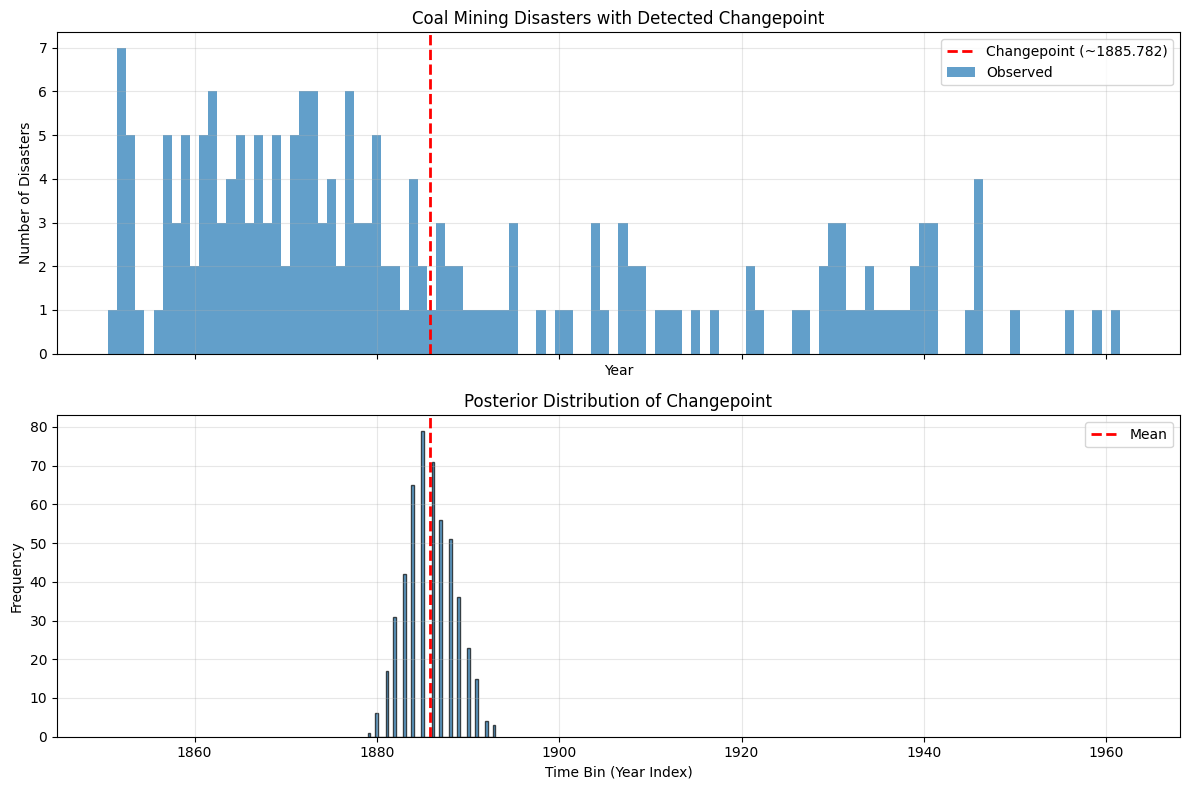

In [6]:
# Visualize results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot data with changepoint
axes[0].bar(coal_years, coal_disasters, width=1.0, alpha=0.7, label='Observed')
axes[0].axvline(tau_mean, color='red', linestyle='--', 
                linewidth=2, label=f'Changepoint (~{tau_mean})')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Disasters')
axes[0].set_title('Coal Mining Disasters with Detected Changepoint')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot changepoint posterior
axes[1].hist(tau_coal, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(tau_mean, color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].set_xlabel('Time Bin (Year Index)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Posterior Distribution of Changepoint')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Example 2: Temperature Change Detection

Simulated temperature data with a changepoint representing climate shift.

In [7]:
# Simulate temperature data with changepoint
np.random.seed(42)
n_years = 100
changepoint_year = 60

# Pre-change: mean=15°C, std=2°C
temp_before = np.random.normal(15, 2, changepoint_year)

# Post-change: mean=17°C, std=2.5°C
temp_after = np.random.normal(17, 2.5, n_years - changepoint_year)

temperature_data = np.concatenate([temp_before, temp_after])
years = np.arange(1920, 1920 + n_years)

print(f"Simulated {n_years} years of temperature data")
print(f"True changepoint at year {years[changepoint_year]}")

Simulated 100 years of temperature data
True changepoint at year 1980


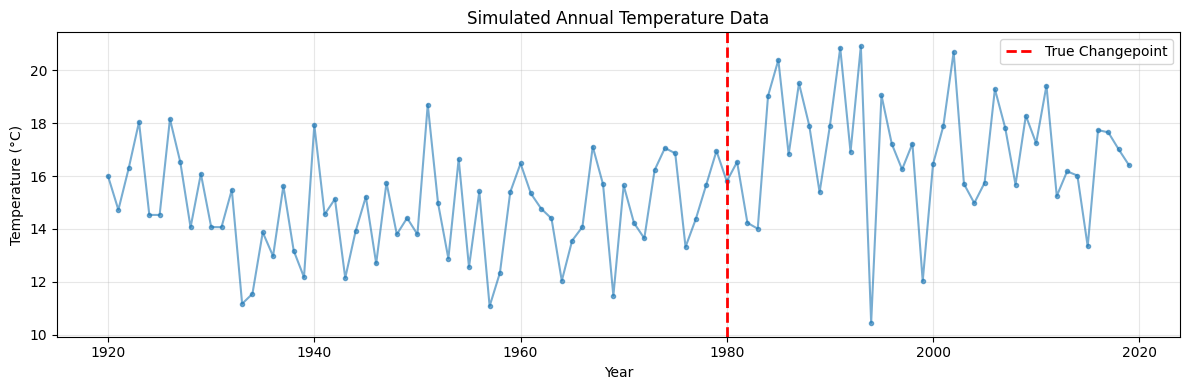

In [8]:
# Visualize temperature data
plt.figure(figsize=(12, 4))
plt.plot(years, temperature_data, 'o-', alpha=0.6, markersize=3)
plt.axvline(years[changepoint_year], color='red', linestyle='--', 
            linewidth=2, label='True Changepoint')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Simulated Annual Temperature Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Prepare data for PyTau (2D format: dimension x time)
temp_data_2d = temperature_data.reshape(1, -1)

# Initialize model
model_temp = GaussianChangepointMean2D(
    data_array=temp_data_2d,
    n_states=2,
    fit_type='vi'
)

# Generate PyMC model
pymc_model_temp = model_temp.generate_model()

# Fit using ADVI
print("Fitting temperature model...")
result = advi_fit(pymc_model_temp, n_fit, n_samples)
if len(result) == 6:
    fitted_model_temp, approx_temp, mu_stack, sigma_stack, tau_temp, observed_data = result
else:
    fitted_model_temp, approx_temp, mu_stack, tau_temp, observed_data = result

print(f"Model fitting completed. Final ELBO: {approx_temp.hist[-1]:.2f}")

Fitting temperature model...


Finished [100%]: Average Loss = 219.25


Model fitting completed. Final ELBO: 219.63


In [10]:
# Convert to years
tau_temp = years[np.vectorize(int)(tau_temp).flatten()]

In [11]:
# Extract changepoint estimates
tau_temp_mean = tau_temp.mean()
tau_temp_std = tau_temp.std()

print(f"Estimated changepoint: {tau_temp_mean:.1f} ± {tau_temp_std:.1f} time bins")
print(f"True changepoint year: {years[changepoint_year]}")
print(f"Error: {abs(int(tau_temp_mean) - years[changepoint_year])} years")

Estimated changepoint: 1977.9 ± 3.9 time bins
True changepoint year: 1980
Error: 3 years


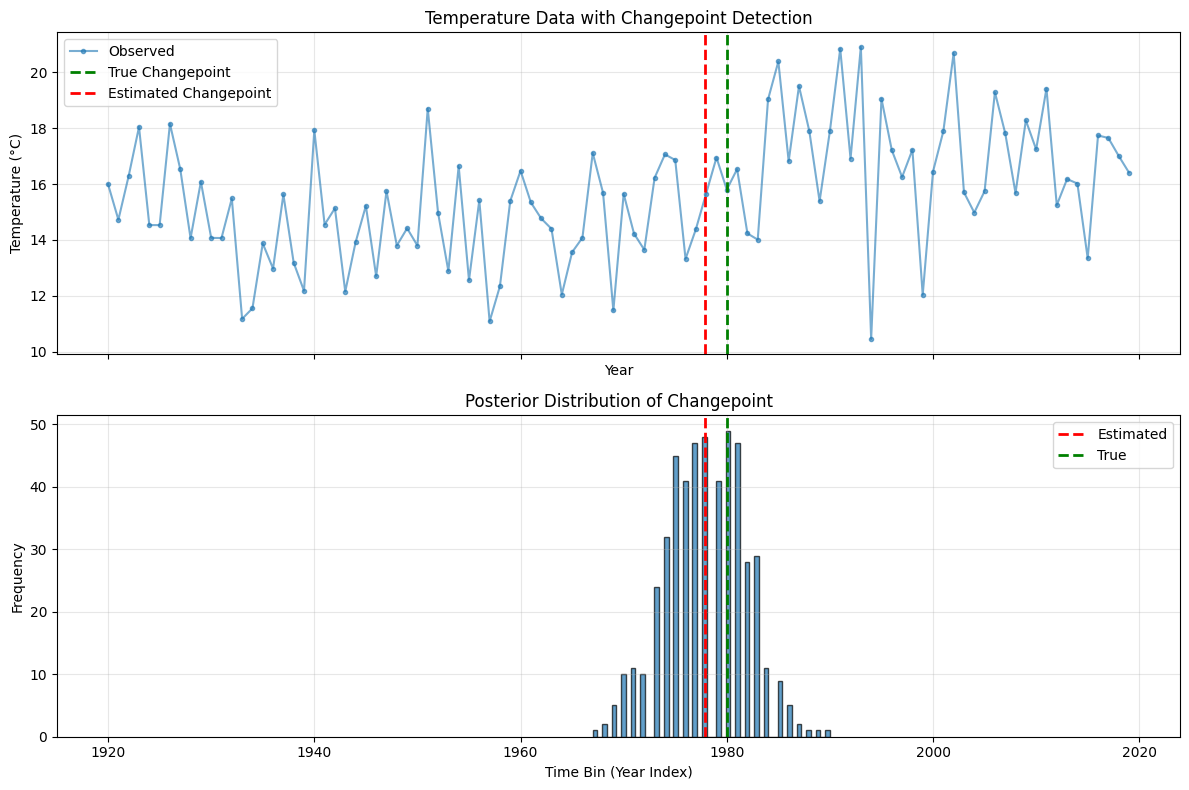

In [12]:
# Visualize results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot data with changepoints
axes[0].plot(years, temperature_data, 'o-', alpha=0.6, markersize=3, label='Observed')
axes[0].axvline(years[changepoint_year], color='green', linestyle='--', 
                linewidth=2, label='True Changepoint')
axes[0].axvline(tau_temp_mean, color='red', linestyle='--', 
                linewidth=2, label='Estimated Changepoint')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Temperature Data with Changepoint Detection')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot changepoint posterior
axes[1].hist(tau_temp, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(tau_temp_mean, color='red', linestyle='--', linewidth=2, label='Estimated')
axes[1].axvline(years[changepoint_year], color='green', linestyle='--', linewidth=2, label='True')
axes[1].set_xlabel('Time Bin (Year Index)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Posterior Distribution of Changepoint')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

These examples demonstrate that PyTau's changepoint detection methods are applicable beyond neuroscience:

1. **Coal Mining Disasters**: Historical event count data (Poisson model)
2. **Temperature Data**: Continuous measurements with mean shifts (Gaussian model)

The same Bayesian changepoint framework can be applied to:
- Economic time series (market regime changes)
- Environmental monitoring (pollution levels, species populations)
- Medical data (disease progression, treatment effects)
- Network traffic analysis (anomaly detection)
- Manufacturing quality control
- Any sequential data where state transitions are of interest